# Counterfactual Regret Minimization with Kuhn Poker

This notebook gives an introduction to
Counterfactual Regret Minimization using the game Kuhn Poker.

If you have comments find me on [Twitter(@vpj)](https://twitter.com/vpj), or open an issue
in the [Github repo](https://github.com/lab-ml/poker).

## The Game

[Kuhn Poker](https://en.wikipedia.org/wiki/Kuhn_poker) is a two player
3-card betting game.
The players are dealt one card each out of Ace, King and Queen (no suits).
There are only three cards in the pack so one card is left out.
Ace beats King and Queen and King beats Queen - just like in normal ranking of cards.

Both players ante $S$ chips (blindly bet $S$ chips).
After looking at the cards,
the first player can either pass or bet $1$ chip.
* If first player passes, the the player with higher card wins the pot.
* If first player bets, the second play can bet (i.e. call) $1$ chip or pass (i.e. fold).
    * If the second player bets and the  player with the higher card wins the pot.
    * If the second player passes (i.e. folds) the first player gets the pot.

This game is played repeatedly and a good strategy will optimize for the
long term utility (or winnings).

Here's some example games:

* `KAp` - Player 1 gets *K*. Player 2 gets *A*. Player 1 passes. Player 2 doesn't get a betting chance and Player 2 wins the pot of $2S$ chips.
* `QKbp` - Player 1 gets *Q*. Player 2 gets *K*. Player 1 bets a chip. Player 2 passes (folds). Player 1 gets the pot of $2S+1$ because Player 2 folded.
* `QAbb` - Player 1 gets *Q*. Player 2 gets *A*. Player 1 bets a chip. Player 2 also bets (calls). Player 2 wins the pot of $2S+2$.

## Nash Equilibrium

By [Nash theorem](https://mathworld.wolfram.com/NashsTheorem.html)
this game has a
[Nash equilibrium](https://en.wikipedia.org/wiki/Nash_equilibrium).
That is, there exists a combination strategies for the two players, such that
neither of them can increase utility by changing only her strategy.

Let's try to derive the Nash equilibrium mathematically,
before trying Counter Factual Regret Minimization.

1. If first player has an A he should always bet.
2. If second player has an A he should bet (if first player did bet).
3. If second player has a Q he should pass.
4. If first player has a K, because of 1. and 2., he would only lose if he bets. So first player should pass if he has a K.
5. If first player has a Q, he should sometimes bluff and bet. Lets say first player bets with probabiliy $p_1$ if he gets a Q.
6. Similarly the second player will bet with probability $p_2$ if he gets a K (if first player did bet).

Then the total utility for the first player for cards (AK, AQ, KA, KQ, QA, QK) is

$$
\begin{align}
U_1 = \frac{1}{6} \big[ 
& + (1 + S) p_2 + S (1 - p_2) \label{AK}\tag{AK} \\
& + S \label{AQ}\tag{AQ} \\
& - S \label{KA}\tag{KA} \\
& + S \label{KQ}\tag{KQ} \\
& - (1 + S) p_1 - S (1 - p_1) \label{QA}\tag{QA} \\
& - (1 + S) p_1 p_2 + S p_1 (1 - p_2) - S (1 - p_1)
\big] \label{QK}\tag{QK} \\
= \frac{1}{6} \big[ 
& + S + p_2 \\
& + S \\
& - S - p_1 \\
& - p_1 p_2 - 2 S p_1 p_2 + 2 S p_1 - S
\big] \\
= \frac{1}{6} \big[ 
& + p_2 - p_1 - p_1 p_2 - 2 S p_1 p_2 + 2 S p_1
\big] \\
= \frac{1}{6} \big[ 
& + p_1 (2 S - 1 - p_2 - 2 S p_2 ) + p_2 
\big] \label{a}\tag{1}\\
= \frac{1}{6} \big[ 
& + p_2 (1 - p_1 - 2 S p_1) - p_1 + 2 S p_1
\big] \label{b}\tag{2}\\
\end{align}
$$

Total utility for second player is $U_2 = -U_1$.

From $(2)$, $1 - p_1 - 2 S p_1 \gtrless 0 \equiv \frac{1}{1 + 2 S} \gtrless p_1$

**Case 1:** If $\frac{1}{1 + 2 S} < p_1$,
second player will pick $p_2 = 1$,
and max utility for first player would be
$\frac{1}{6} [1 - 2 p_1] = \frac{1}{6} \frac{2 S - 1}{1 + 2 S}$

**Case 2:** If $\frac{1}{1 + 2 S} > p_1$,
second player will pick $p_2 = 0$,
and max utility for first player would be
$\frac{1}{6} p_1(2 S - 1) = \frac{1}{6} \frac{2 S - 1}{1 + 2 S}$

**Case 3:** If $\frac{1}{1 + 2 S} = p_1$,
the utility will be independent of $p_2$,
and max utility for first player would be
$\frac{1}{6} p_1(2 S - 1) = \frac{1}{6} \frac{2 S - 1}{1 + 2 S}$

In all three cases the best strategy for first player is 
$p_1 = \frac{1}{1 + 2 S}$

Similarly from $(1)$, best strategy for second player is $p_2 = \frac{2 S - 1}{1 + 2 S}$

At this point, neither player can increase their utilities by changing the strategies.
Therefore it is the Nash equilibrium.

Lets try plotting these in charts.

In [1]:
from typing import List, NewType, Dict, cast

import altair as alt
import numpy as np
import torch
from labml import analytics
from labml import logger, experiment, monit, tracker
from labml.logger import Text
from matplotlib import pyplot as plt

$S$, `BLINDS`, is the number of chips each player needs to bet before seeing cards.

In [2]:
BLINDS = 1

Lets calculate $U_1$, `u_1` for all values of $p_1$ (`p_`) and $p_2$ (`p_2`).

In [3]:
p_1, p_2 = np.meshgrid(range(0, 100, 5), range(0, 100, 5))
p_1, p_2 = p_1 / 100, p_2 / 100
p_1 = torch.tensor(p_1, requires_grad=True)
p_2 = torch.tensor(p_2, requires_grad=True)
u_1 = 1/6 * (p_2 - p_1 - p_1 * p_2 - 2 * BLINDS * p_1 * p_2 + 2 * BLINDS * p_1)

In [4]:
def plot_matrix():
    x = p_1.detach().numpy().ravel() # * 100
    y = p_2.detach().numpy().ravel() # * 100
    z = u_1.detach().numpy().ravel()

    data = []
    for i in range(len(x)):
        data.append({
            'p1': x[i],
            'p2': y[i],
            'u1': z[i]
        })

    source = alt.Data(values=data)

    return alt.Chart(source).mark_rect().encode(
        x='p1:N',
        y=alt.Y('p2:N', sort='descending'),
        color='u1:Q'
    )

plot_matrix()

alt.Chart(...)

The above chart shows $U_1$ against $(p_1, p_2)$.

Lets plot the gradients.

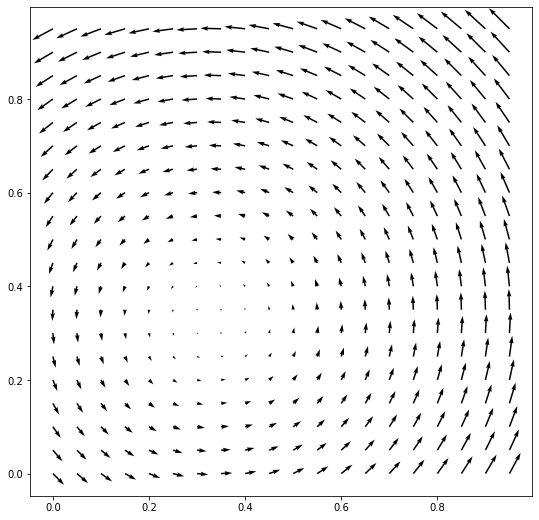

In [5]:
def plot_grads():
    u_1.sum().backward(retain_graph=True)
    p_1_grad = p_1.grad.clone()
    p_1.grad.zero_()
    p_2.grad.zero_()

    (-u_1).sum().backward(retain_graph=True)
    p_2_grad = p_2.grad.clone()
    p_1.grad.zero_()
    p_2.grad.zero_()
    
    _, ax = plt.subplots(figsize=(9, 9))
    quiver = ax.quiver(p_1.detach(), p_2.detach(), p_1_grad, p_2_grad)

    plt.show()

plot_grads()

Nash equilibrium lies around $(0.33, 0.33)$ when $S = 1$.
The gradients seem to circle around it.

## Counterfactual Regret Minimization (CFR)

Counterfactual regret minimization use regret matching to find a strategy
that minimize current regrets.
The average strategy over a large number of iterations will converge to 
Nash equilibrium.

[An Introduction to Counterfactual Regret Minimization](http://modelai.gettysburg.edu/2013/cfr/cfr.pdf)
gives a detailed introduction.
Proofs can be found on
[Monte Carlo Sampling for Regret Minimization inExtensive Games](http://mlanctot.info/files/papers/nips09mccfr.pdf) and
[Regret Minimization in Games with IncompleteInformation](http://martin.zinkevich.org/publications/regretpoker.pdf).

Following is the code for running CFR on Kuhn Poker.

$i$, `Player`, is the player

In [6]:
Player = NewType('Player', int)
PLAYERS = cast(List[Player], [0, 1])

$a$, `Action` is an action performed by a player or by chance.
That is either a betting (`p` for pass and `b` for bet),
or a card dealt (`A`, `K`, `Q`).

In [7]:
Action = NewType('Action', str)
ACTIONS = cast(List[Action], ['p', 'b'])
CHANCES = cast(List[Action], ['A', 'K', 'Q'])

$h$, `History`, is the history of the current game.
That is, the cards dealt and actions taken by the players.
We represent $h$ is a string where the first two letters are the
cards dealt to the two players and the rest are betting actions.

Here are some example histories:

1. `KA` - Player 1 gets *K*. Player 2 gets *A*. It is the Player 1's chance to take an action.
2. `KAp` - Player 1 gets *K*. Player 2 gets *A*. Player 1 passes. The game ends. This is a terminal history.
3. `KAb` - Player 1 gets *K*. Player 2 gets *A*. Player 1 bets a chip. It is the Player 2's chance to take an action.
4. `KAbp` - Player 1 gets *K*. Player 2 gets *A*. Player 1 bets a chip. Player 2 passes. Game ends. This is a terminal history.
5. `KAbb` - Player 1 gets *K*. Player 2 gets *A*. Player 1 bets a chip. Player 2 calls by betting a chip. Game ends. This is a terminal history.

In [8]:
History = NewType('History', str)

$I$, InfoSet`, is an **information set**.
This represents the information available to the player.
This is like the state of the agent.
In case of Kuhn poker, it's the card in their hand and the betting info.

In [9]:
class InfoSet:
    regret: Dict[Action, float]
    strategy: Dict[Action, float]
    cumulative_strategy: Dict[Action, float]
    average_strategy: Dict[Action, float]

    def __init__(self, key: str):
        self.key = key
        self.regret = {a: 0 for a in actions(self)}

        n_actions = len(actions(self))
        self.strategy = {a: 1 / n_actions for a in actions(self)}
        self.cumulative_strategy = {a: 0 for a in actions(self)}
        self.average_strategy = {a: 0 for a in actions(self)}
        
    def __repr__(self):
        return repr(self.strategy)


INFO_SETS: Dict[str, InfoSet] = {}

`player` gives the current player.

In [10]:
def player(h: History):
    return cast(Player, len(h) % 2)

Function `info_set` gives the Information set $I$ for a given history $h$.

Here are some example history & infoormation set pairs:

* `KA` - Player 1 is the current player. He can see his card *K*. So the information set is `K`.
* `KAb` - Player 2 is the current player. He can see his card *A* and the betting history *b*. So the information set is `Ab`.

In [11]:
def info_set(h: History) -> InfoSet:
    i = player(h)
    visible = h[i] + h[2:]
    if visible not in INFO_SETS:
        INFO_SETS[visible] = InfoSet(visible)

    return INFO_SETS[visible]

$A(I)$, `actions`, gives the set of actions the player
can take at the current state represented by $I$.

In [12]:
def actions(I: InfoSet):
    return ACTIONS

Function `is_chance` checks if the next action is a chance action,
and `sample_chance` samples an action at a chance action.
This is used to deal cards.

In [13]:
def is_chance(h: History) -> bool:
    return len(h) < 2

def sample_chance(h: History) -> Action:
    while True:
        r = np.random.randint(len(CHANCES))
        chance = CHANCES[r]
        for c in h:
            if c == chance:
                chance = None
                break

        if chance is not None:
            return cast(Action, chance)

$\sigma_i^t (I)$, `strategy`, is the strategy of player $i$ at iteration $t$ of training for
information set $I$. It gives the probabilities for actions $a \in A(I)$.

In [14]:
def strategy(I: InfoSet):
    return I.strategy

$u_i(z)$, `terminal_utility`, is the utility of player $i$ at terminal game history $z$.
A terminal game history is history of a game that has completed.
`is_terminal` returns if a given history is a terminal, and

In [15]:
def is_terminal(h: History):
    if len(h) <= 2:
        return False
    if h[-1] == 'p':
        return True
    if h[-2:] == 'bb':
        return True

    return False

def terminal_utility(h: History, i: Player) -> float:
    winner = -1 + 2 * (h[0] < h[1])
    utility = 0
    if h[-2:] == 'bp':
        utility = BLINDS
    elif h[-2:] == 'bb':
        utility = winner * (1 + BLINDS)
    elif h[-1] == 'p':
        utility = winner * BLINDS

    if i == PLAYERS[0]:
        return utility
    else:
        return -utility

Expected utility at $h$ for player $i$ is, with with $\sigma$ strategies of players is,

$$u_i(\sigma, h) = \sum_{z \in Z, h \sqsubset z} \pi^\sigma (h, z) u_i(z)$$

where,
* $Z$ is the set of all terminal histories
* $h \sqsubset z$ means $h$ is a prefix of $z$
* $\pi^\sigma (h, z)$ is the probability of reaching $z$ from $h$ with $\sigma$ strategies of players.

$u_i(\sigma_{I \to a}, h)$ is the utility if it always took action $a$ at current information set.

We compute $u$ recursively,

$$
\begin{align}
u_i(\sigma_{I \to a}, h) &= u_i(\sigma, h a) \\
u_i(\sigma, h) &= \sum_{a \in A(I)} \sigma(I, a) u_i(\sigma_{I \to a}, h) \\
\end{align}
$$

*Counterfactual value* at a non-terminal history h is,
$$v_i(\sigma, h) = \pi_{-i}^\sigma (h) u_i(\sigma, h)$$

where
* $\pi_{-i}^\sigma (h)$ is the probability of reaching $h$ if player $i$ took all of its actions that lead to $h$ with a probability of $1$.

*Counterfactual regret* of not taking action $a$ at history $h$ is
$$r_i(h,a) = v_i(\sigma_{I \to a}, h) - v_i(\sigma, h)$$

*Counterfactual regret* of not taking action $a$ at information set $I$ is
$$r_i(I,a) = \sum_{h \in I} r_i(h, a)$$

The cumulative counterfactual regret over all iterations up to $T$ is,
$$R_i^T (I, a) = \sum_{t=1}^T r_i^t (I, a)$$

We keep track of $R_i^T$,

In [16]:
def regret(I: InfoSet):
    return I.regret

`update` updates $R_i^T$ with counterfactural values.

* `va[a]` is $v_i(\sigma_{I \to a}, h)$
* `v` is $v_i(\sigma, h)$

In [17]:
def update_regrets(I: InfoSet, v: float, va: Dict[Action, float], i: Player):
    for a in actions(I):
        regret(I)[a] = regret(I)[a] + (va[a] - v)

Strategy is calculated with Hart and Mas-Collell's regret matching.
$$
\begin{align}
R_i^{T,+} (I, a) &= \max (R_i^T (I, a), 0)
\\
\sigma_i^{T + 1} (I, a) &= \begin{cases}
\frac{R_i^{T,+} (I, a)}{\sum_{a' \in A(I)} R_i^{T,+} (I, a')},  &\text{if $\sum_{a' \in A(I)} R_i^{T,+} (I, a') > 0$}\\
\frac{1}{|A(I)|}  & \text{otherwise}\\
\end{cases}
\end{align}
$$

In [18]:
def calculate_new_strategy(I: InfoSet):
    r_plus = {a: max(r, 0) for a, r in regret(I).items()}
    r_plus_sum = sum(r for r in r_plus.values())
    n_actions = len(actions(I))
    for a in actions(I):
        if r_plus_sum > 0:
            strategy(I)[a] = r_plus[a] / r_plus_sum
        else:
            strategy(I)[a] = 1 / n_actions

Average strategy for player $i$ from iterations up to $T$ is,
$$\bar{\sigma}_i^T (I, a) =
\frac{\sum_{t=1}^T \pi_i^{\sigma^t} (I) \sigma_i^T(I, a)}
{\sum_{t=1}^T \pi_i^{\sigma^t} (I)}$$

where,
* $\pi_i^\sigma$ is the probability of reaching $ℎ$ if all players except $𝑖$ took actions that lead to $ℎ$ with a probability of $1$.

`update_cumulative_strategy` keeps the sum of $\pi_i^\sigma \sigma_i^T(I, a)$ and
`calculate_average_strategy` calculates $\bar{\sigma}_i^T (I, a)$.
* `pi_i` is $\pi_i^\sigma$

In [19]:
def update_cumulative_strategy(I: InfoSet, pi_i: float):
    for a in actions(I):
        I.cumulative_strategy[a] += pi_i * strategy(I)[a]
        
def calculate_average_strategy(I: InfoSet):
    strategy_sum = sum(I.cumulative_strategy[a] for a in actions(I))
    n_actions = len(actions(I))

    for a in actions(I):
        if strategy_sum > 0:
            I.average_strategy[a] = I.cumulative_strategy[a] / strategy_sum
        else:
            I.average_strategy[a] = 1 / n_actions            

This is the main recursive counterfactual regret minimization function.
It recursevely explores the game tree and calculates a new stratgy.
`cfr` returns $u_i(\sigma, h)$.

* `pi[i]` is $\pi_i^\sigma$
* `ua[a]` is $u_i(\sigma_{I \to a}, h)$
* `u` is $u_i(\sigma, h)$
* `va[a]` is $v_i(\sigma_{I \to a}, h)$
* `u` is $v_i(\sigma, h)$
* `pi_neg_i` is $\pi_{-i}^\sigma$

In [20]:
def cfr(h: History, i: Player, pi: Dict[Player, float]) -> float:
    if is_terminal(h):
        return terminal_utility(h, i)
    elif is_chance(h):
        a = sample_chance(h)
        return cfr(h + a, i, pi)

    I = info_set(h)
    
    pi_neg_i = 1
    for j, pi_j in pi.items():
        if j != player(h):
            pi_neg_i *= pi_j

    ua = {}
    u = 0
    for a in actions(I):
        pi_next = pi.copy()
        pi_next[player(h)] = strategy(I)[a]
        ua[a] = cfr(h + a, i, pi_next)
        u += strategy(I)[a] * ua[a]

    va = {a: pi_neg_i * ua[a] for a in actions(I)}
    v = pi_neg_i* u

    if player(h) == i:
        update_regrets(I, v, va, i)
        update_cumulative_strategy(I, pi[i])
        
    return u

We iterate about $5,000$ iterations for illustrations. The average strategy settles completely after about $25,000$ iterations.

In [21]:
def solve():
    tracker.set_scalar('')
    for t in monit.loop(5_000):
        for i in PLAYERS:
            cfr('', i, {p: 1 for p in PLAYERS})
        for I in INFO_SETS.values():
            calculate_new_strategy(I)
            calculate_average_strategy(I)
            if t == 9:
                for a in ACTIONS:
                    tracker.set_scalar(f'strategy.{I.key}.{a}', is_print=False)
                    tracker.set_scalar(f'average_strategy.{I.key}.{a}', is_print=False)
                    tracker.set_scalar(f'regret.{I.key}.{a}', is_print=False)
            if (t + 1) % 10 == 0:
                for a in actions(I):
                    tracker.save({
                        f'strategy.{I.key}.{a}': strategy(I)[a],
                        f'average_strategy.{I.key}.{a}': I.average_strategy[a],
                        f'regret.{I.key}.{a}': regret(I)[a]
                    })
    
    logger.log('Average Strategy', Text.title)
    logger.inspect({k: I.average_strategy for k, I in INFO_SETS.items()})

Lets create an experiment and start run CFR.

In [22]:
experiment.create(name='kuhn_poker', writers={'sqlite'})
experiment.start()

solve()

### Analysis

In [23]:
ind = analytics.runs(experiment.get_uuid())

In [24]:
analytics.distribution(ind.average_strategy_A_b + ind.average_strategy_Ab_b,
                      width=600, height=300)

alt.HConcatChart(...)

We can see dominant strategies
(when first player gets an A, when second player gets an A)
have settled early on.

In [25]:
analytics.distribution(ind.average_strategy_Q_b + ind.average_strategy_Kb_b + 
                       ind.strategy_Q_b + ind.strategy_Kb_b,
                       width=600, height=300)

alt.HConcatChart(...)

However the strategies for betting with a 
Q for first player and betting with a K for second player
take time to converge.

The average strategies $\bar{\sigma}_i^T (I, a)$ oscillate around Nash equilibrium while converging.
The current strategy $\sigma_i^T (I, a)$ goes in cycles.

We can see them better on a scatter plots. Here $\sigma_i^T(I, a)$ seems to be moving around.

In [26]:
analytics.scatter(ind.strategy_Q_b, ind.strategy_Kb_b, noise=(0.02, 0.02),
                  width=400, height=400)

alt.VConcatChart(...)

Whilst, average strategies $\bar{\sigma}_i^T(I, a)$ are spiraling into the Nash equilibrium.

In [27]:
analytics.scatter(ind.average_strategy_Q_b, ind.average_strategy_Kb_b,
                  width=400, height=400)

alt.VConcatChart(...)

You can clone [this notebook from Github](https://github.com/lab-ml/poker/blob/master/kuhn_cfr/kuhn_cfr.ipynb).